In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import datetime as dt
from datetime import datetime
pd.set_option('display.max_rows', 50)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


Tables Schema and Relationships


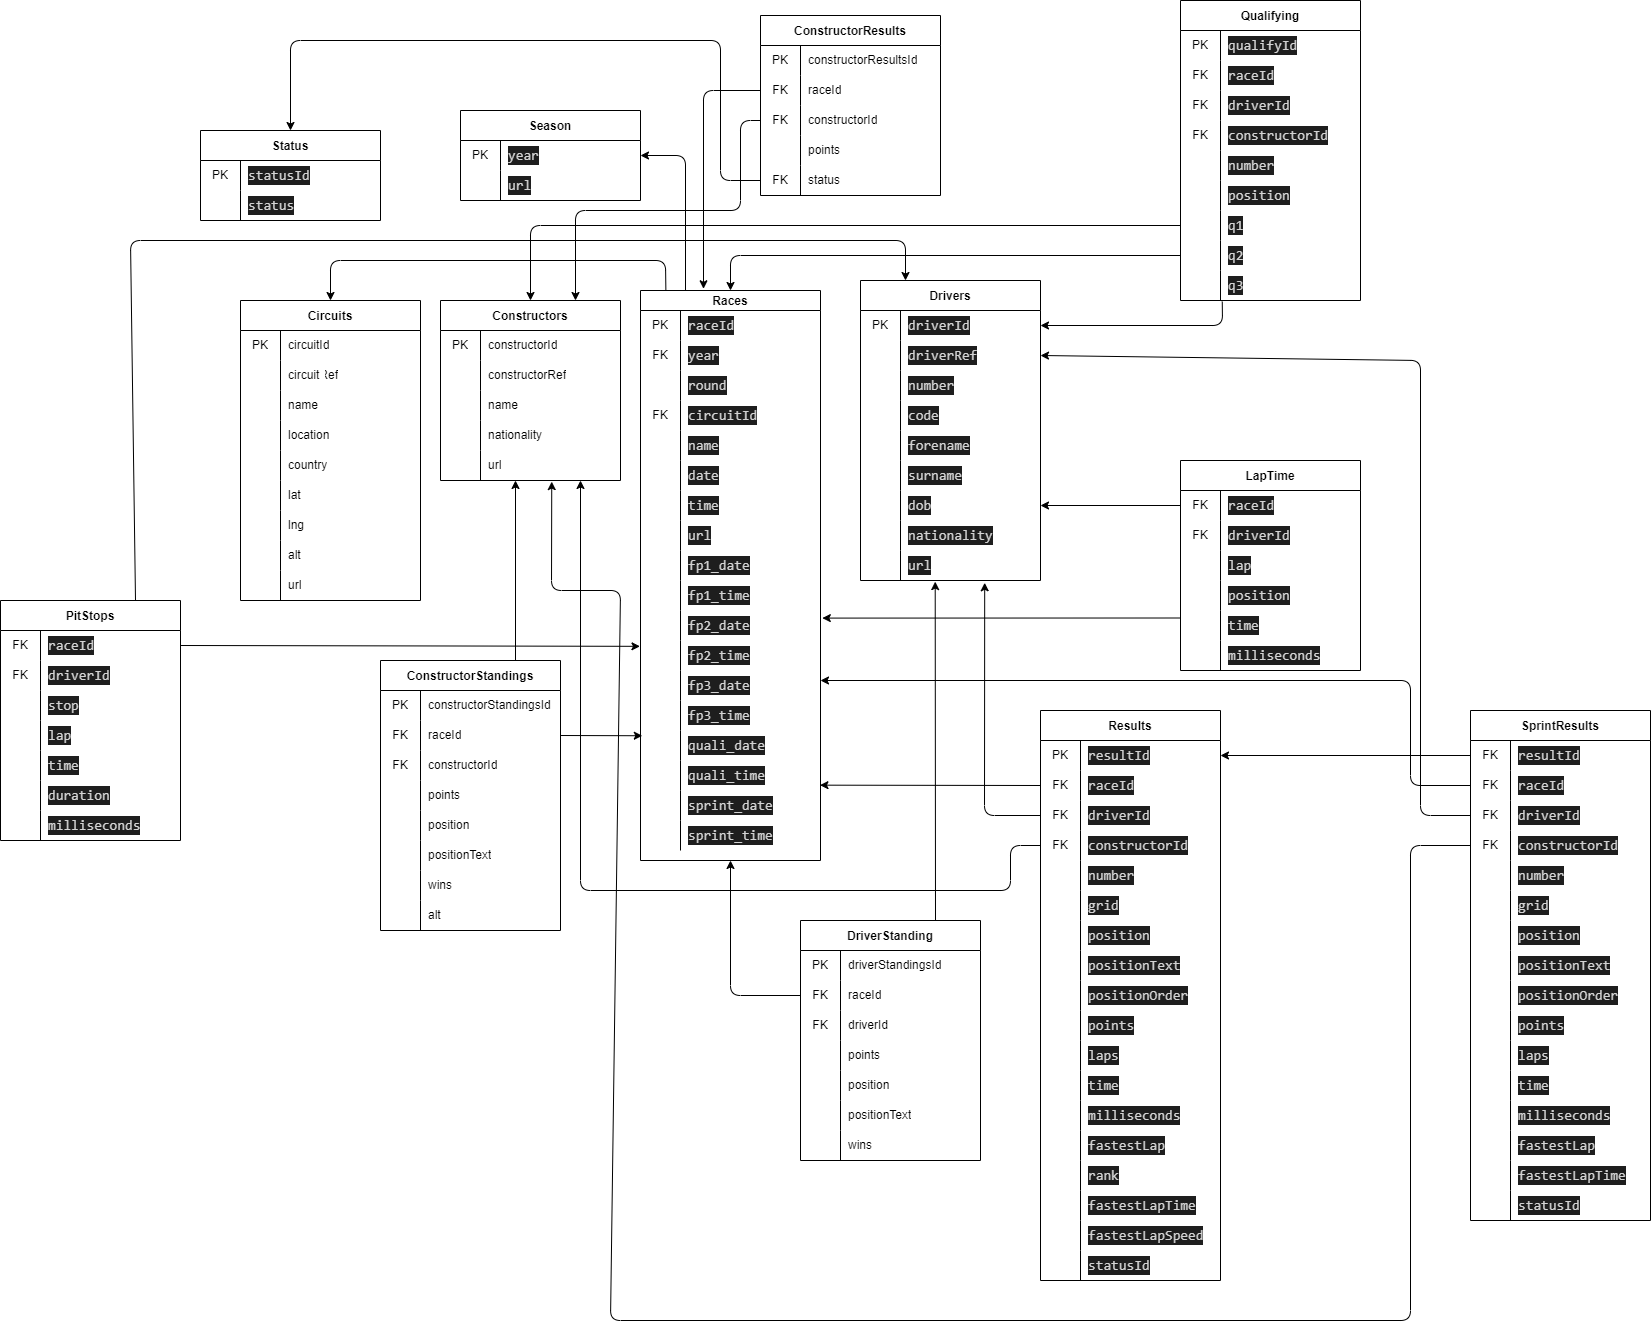

In [2]:

from IPython.display import Image
Image(filename='..\drawing\\relationship.png')


In [3]:
# Importing all the CSVs as dataframes
df_circuits = pd.read_csv('..\data\circuits.csv', index_col=False)
df_constructor_results = pd.read_csv(
    '..\data\constructor_results.csv', index_col=False)
df_constructor_standings = pd.read_csv(
    '..\data\constructor_standings.csv', index_col=False)
df_constructors = pd.read_csv('..\data\constructors.csv', index_col=False)
df_driver_standings = pd.read_csv(
    '..\data\driver_standings.csv', index_col=False)
df_drivers = pd.read_csv('..\data\drivers.csv', index_col=False)
df_lap_times = pd.read_csv('..\data\lap_times.csv', index_col=False)
df_pit_stops = pd.read_csv('..\data\pit_stops.csv', index_col=False)
df_qualifying = pd.read_csv('..\data\qualifying.csv', index_col=False)
df_races = pd.read_csv('..\data\\races.csv', index_col=False)
df_results = pd.read_csv('..\data\\results.csv', index_col=False)
df_seasons = pd.read_csv('..\data\seasons.csv', index_col=False)
df_sprint_results = pd.read_csv('..\data\sprint_results.csv', index_col=False)
df_status = pd.read_csv('..\data\status.csv', index_col=False)


In [4]:
# Merging results with Racers, Drivers, Constructors and Status
df = (df_results.merge(df_races[['raceId', 'name', 'date']], on='raceId', how='left')
      .merge(df_drivers[['driverId', 'driverRef', 'nationality', 'dob']], on='driverId', how='left')
      .merge(df_constructors[['constructorId', 'name', 'nationality']], on='constructorId', how='left')
      .merge(df_status[['statusId', 'status']], on='statusId', how='left')
      )
df_eda = df.rename(columns={"name_x": "RacerName", "name_y": "ConstructorName", "nationality_x": "RacerNacionality", "nationality_y": "ConstructorNacionality"})


In [5]:
#renaming Columns
df = df[['resultId', 'name_x', 'date', 'driverRef', 'nationality_x', 'dob', 'name_y', 'nationality_y', 'status', 'number', 'positionOrder', 'points', 'laps', 'milliseconds', 'fastestLap',
         'rank', 'fastestLapTime', 'fastestLapSpeed', 'status']].rename(columns={"name_x": "RacerName", "name_y": "ConstructorName", "nationality_x": "RacerNacionality", "nationality_y": "ConstructorNacionality"})
df = df.replace('\\N', 0)  # Replacing nulls per 0


In [6]:
# Converting objects in Categories and Datetime
cat_cols = ['RacerName', 'driverRef', 'RacerNacionality',
            'ConstructorName', 'ConstructorNacionality', 'positionOrder', 'rank', 'status']
df[cat_cols] = df[cat_cols].astype('category')
df['fastestLapTime'] = pd.to_datetime(df['fastestLapTime'], infer_datetime_format=True)
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df['dob'] = pd.to_datetime(df['dob'], infer_datetime_format=True)

# Sort data by race date
df.sort_values(by='date', inplace=True)

# Create a reference to the original dataframe for plotting



Since Lewis Hamilton is the current biggest winner in F1 I decided to get some of the highlight of him and some data regards Ciscuits / Performances

In [7]:
px.bar(df_eda.query('position == "1"')
       .groupby(["driverRef"])["RacerName"].agg({'count'})
       .sort_values('count', ascending=False).head(20), title='Top 20 Race Winners'
       )


Racers and its winning circuits


In [8]:
(df_eda.query('position == "1"')
 .groupby(["driverRef", "RacerName"])["driverRef"].agg({'count'})
 .query('count >= 1')
 .sort_values('driverRef', ascending=True)
 )


count
driverRef RacerName                       
alboreto  Belgian Grand Prix             1
          Caesars Palace Grand Prix      1
          Canadian Grand Prix            1
          Detroit Grand Prix             1
          German Grand Prix              1
...                                    ...
webber    Brazilian Grand Prix           2
          British Grand Prix             2
          German Grand Prix              1
          Hungarian Grand Prix           1
          Spanish Grand Prix             1

[636 rows x 1 columns]

Number of unique circuits the racers won


In [9]:
px.bar(df_eda.query('position == "1"')
       .groupby(["driverRef"])["RacerName"].agg({'nunique'})
       .query('nunique >= 1')
       .sort_values('nunique', ascending=False), title='Ranking of Racers that won different circuits ( uniques )'
       )


Circuits and it`s respective winners along the time


In [10]:
(df_eda.query('position == "1"')
 .groupby(["RacerName", "driverRef"])["RacerName"].agg({'count'})
 .query('count >= 1')
 .sort_values('RacerName', ascending=False)
 )


count
RacerName                     driverRef            
United States Grand Prix West watson              1
                              reutemann           1
                              regazzoni           1
                              piquet              1
                              mario_andretti      1
...                                             ...
Abu Dhabi Grand Prix          max_verstappen      2
                              bottas              1
                              rosberg             1
                              vettel              3
70th Anniversary Grand Prix   max_verstappen      1

[636 rows x 1 columns]

Ranking circuits that had repetitive winners


In [11]:
(df_eda.query('position == "1"')
 .groupby(["RacerName", "driverRef"])["RacerName"].agg({'count'})
 .query('count >= 2')
 .sort_values('count', ascending=False)
 )


count
RacerName                driverRef                
British Grand Prix       hamilton                8
French Grand Prix        michael_schumacher      8
Hungarian Grand Prix     hamilton                8
Canadian Grand Prix      michael_schumacher      7
                         hamilton                7
...                                            ...
French Grand Prix        gurney                  2
                         hamilton                2
                         hawthorn                2
                         lauda                   2
United States Grand Prix stewart                 2

[233 rows x 1 columns]

How many unique circuits have Lewis Hamilton already won?

How many unique circuits have Lewis Hamilton did not win yet?


In [12]:
circuits = df_eda['RacerName'].unique()
hamilton_circuits = df_eda.query('position == "1" and driverRef == "hamilton"')['RacerName'].unique()

# Count the number of circuits won and lost by Hamilton
num_wins = len([circuit for circuit in circuits if circuit in hamilton_circuits])
num_losses = len([circuit for circuit in circuits if circuit not in hamilton_circuits])

# Print the results using f-strings
print(f"Lewis Hamilton has won in {num_wins} circuits")
print(f"Lewis Hamilton has not won in {num_losses} circuits")

Lewis Hamilton has won in 31 circuits
Lewis Hamilton has not won in 22 circuits


Validation dataset ( races of 2022 )

In [13]:
validation = df[df["date"].dt.year == 2022]
data = df[df["date"].dt.year != 2022]

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [15]:

le = preprocessing.LabelEncoder()

Defining data types for validation

In [16]:
def preprocess_data(X):
    """
    Preprocesses the given dataframe X by applying label encoding and
    converting datetime columns to numeric format.

    Args:
        X: a pandas dataframe containing the input features

    Returns:
        The preprocessed pandas dataframe
    """
    X = X.copy()
    label_cols = ['RacerName', 'driverRef', 'RacerNacionality',
                  'ConstructorName', 'ConstructorNacionality', 'status']
    X[label_cols] = X[label_cols].apply(preprocessing.LabelEncoder().fit_transform)
    X['fastestLapTime'] = pd.to_numeric(pd.to_datetime(X['fastestLapTime']))
    X['date'] = pd.to_numeric(pd.to_datetime(X['date']))
    X['dob'] = pd.to_numeric(pd.to_datetime(X['dob']))
    return X

X_val = validation[['resultId', 'RacerName', 'date', 'driverRef', 'RacerNacionality', 'dob', 'ConstructorName', 'ConstructorNacionality',
                    'number', 'laps', 'milliseconds', 'fastestLap', 'fastestLapTime', 'fastestLapSpeed', 'status']]
y_val = validation[['points']]

X_val = preprocess_data(X_val)

X = data[['resultId', 'RacerName', 'date', 'driverRef', 'RacerNacionality', 'dob', 'ConstructorName', 'ConstructorNacionality',
        'number','laps', 'milliseconds', 'fastestLap','fastestLapTime', 'fastestLapSpeed', 'status']]
y = data[['points']]

X = preprocess_data(X)

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)
rfc = RandomForestRegressor(max_depth=2, random_state=0)
rfc.fit(X_train, Y_train.values.ravel())


RandomForestRegressor(max_depth=2, random_state=0)

In [19]:

predictions = rfc.predict(X_test)
predictions = [round(x) for x in predictions]
Y_test['predictions'] = predictions
print('RMSE of the Random Forest Model for test data ( Considering ALL Years) : {0}'.format(mean_squared_error(Y_test['points'], predictions)))


RMSE of the Random Forest Model for test data ( Considering ALL Years) : 8.350253503937008


In [20]:
predictions_val = rfc.predict(X_val)
validation = validation.assign(predicted_RF=np.round(predictions_val))
rgb = GradientBoostingRegressor(random_state=0)
rgb.fit(X_train, Y_train.values.ravel())
rgb_pred = rgb.predict(X_val)
rgb_pred = [round(x) for x in rgb_pred]

In [21]:
validation = validation.assign(predicted_rgb=np.round(rgb_pred))
print('RMSE of the Gradient Boost Model on the Validation data: {0}'.format(mean_squared_error(validation['points'], rgb.predict(X_val))))


RMSE of the Gradient Boost Model on the Validation data: 44.890037843466445


Validation Data Predictions Visualization

In [27]:
gb_data = validation.groupby(['driverRef'])['points','predicted_RF','predicted_rgb'].agg(
    {'sum'}).reset_index().sort_values(('points', 'sum'), ascending=False)[:20]
s = gb_data.style.bar(color='#d65f5f')
s


,driverRef,points,predicted_RF,predicted_rgb
,,sum,sum,sum
516,max_verstappen,242.000000,99.000000,74
458,leclerc,164.000000,90.000000,70
604,perez,163.000000,90.000000,28
689,russell,153.000000,108.000000,71
341,hamilton,145.000000,109.000000,146
695,sainz,145.000000,81.000000,66
577,norris,72.000000,100.000000,111
580,ocon,55.000000,92.000000,58
101,bottas,44.000000,74.000000,60


In [23]:
print('RMSE of the Random Forrest Model on the Validation data : {0}'.format(mean_squared_error(validation['points'], rfc.predict(X_val))))

print('RMSE of the Gradient Boost Model on the Validation data: {0}'.format(mean_squared_error(validation['points'], rgb.predict(X_val))))

RMSE of the Random Forrest Model on the Validation data : 37.93257480489247
RMSE of the Gradient Boost Model on the Validation data: 44.890037843466445


In [35]:
rfc.max_depth

2

In [36]:
from sklearn.model_selection import GridSearchCV 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5,10,15,20,50,80, 90, 100, 110],
    'max_features': [2, 3, 4, 5],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12, 15],
    'n_estimators': [50, 100, 200, 300, 1000, 10000]
}# Create a based model
rf = RandomForestRegressor()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [37]:
#grid_search.fit(X_train, Y_train.values.ravel())

Fitting 3 folds for each of 2592 candidates, totalling 7776 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': [5, 10, 15, 20, 50, 80, 90, 100, 110],
                         'max_features': [2, 3, 4, 5],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12, 15],
                         'n_estimators': [50, 100, 200, 300, 1000, 10000]},
             verbose=2)

In [43]:
print('''{'bootstrap': True,
 'max_depth': 100,
 'max_features': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 300}''')

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 300}


In [41]:
print('RMSE of the Gradient Boost Model on the Validation data: {0}'.format(mean_squared_error(validation['points'], grid_search.predict(X_val))))

RMSE of the Gradient Boost Model on the Validation data: 51.91326850701954


In [42]:
validation = validation.assign(predicted_GRID=np.round(grid_search.predict(X_val)))
gb_data = validation.groupby(['driverRef'])['points','predicted_RF','predicted_rgb','predicted_GRID'].agg(
    {'sum'}).reset_index().sort_values(('points', 'sum'), ascending=False)[:20]
s = gb_data.style.bar(color='#d65f5f')
s

,driverRef,points,predicted_RF,predicted_rgb,predicted_GRID
,,sum,sum,sum,sum
516,max_verstappen,242.000000,99.000000,74,37.000000
458,leclerc,164.000000,90.000000,70,30.000000
604,perez,163.000000,90.000000,28,22.000000
689,russell,153.000000,108.000000,71,46.000000
341,hamilton,145.000000,109.000000,146,61.000000
695,sainz,145.000000,81.000000,66,35.000000
577,norris,72.000000,100.000000,111,39.000000
580,ocon,55.000000,92.000000,58,32.000000
101,bottas,44.000000,74.000000,60,35.000000


The Performance after gridsearch did not improve the results against the validation data.

It`s possible to already admit that we could not create a model capable of predict the results of F1 starting in 2022 with a good RMSE.
The key thing is that this year was the game changed, and Redbull assumed the leadership domiantion and Mercedes is currently strugling with its car performance.